In [2]:
#options(browser="firefox")
library(microViz)
library(ggplot2)
library(phyloseq)
library('reshape2')
library('dplyr')
library('plyr')
library('vegan')
library("microbiome")

microViz version 0.12.1 - Copyright (C) 2021-2024 David Barnett
! Website: https://david-barnett.github.io/microViz
✔ Useful?  For citation details, run: `citation("microViz")`
✖ Silence? `suppressPackageStartupMessages(library(microViz))`

Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


------------------------------------------------------------------------------

You have loaded plyr after dplyr - this is likely to cause problems.
If you need functions from both plyr and dplyr, please load plyr first, then dplyr:
library(plyr); library(dplyr)

------------------------------------------------------------------------------


Attaching package: ‘plyr’


The following objects are masked from ‘package:dplyr’:

    arrange, count, desc, failwith, id, mutate, rename, summarise,
    summarize


Loading required package: permute

Loading requ

In [3]:
tax <- "data/lineage.tsv"
otu <- "data/otus.tsv"
meta <- "data/meta.tsv"

In [4]:
meta_df <- read.csv(meta, sep = "\t")
rownames(meta_df) <- meta_df$file

In [5]:
head(meta_df)

,file,sample,origin,body_site,simulated
,<chr>,<chr>,<chr>,<chr>,<chr>
SRS013506,SRS013506,SRS013506,gold_standard,buccal mucosa,False
SRS050029,SRS050029,SRS050029,gold_standard,buccal mucosa,False
SRS1041031,SRS1041031,SRS1041031,gold_standard,feces,False
SRS014689,SRS014689,SRS014689,gold_standard,throat,False
SRS065335,SRS065335,SRS065335,gold_standard,throat,False
SRS104912,SRS104912,SRS104912,gold_standard,feces,False


In [6]:
tax_df <- read.csv(tax, sep = "\t")
rownames(tax_df) <- tax_df$taxon
tax_df <- subset(tax_df, select=-c(taxon))
head(tax_df)

,kindom,phylum,class,order,family,genus,species
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
7,Bacteria,Pseudomonadota,Alphaproteobacteria,Hyphomicrobiales,Xanthobacteraceae,Azorhizobium,Azorhizobium caulinodans
9,Bacteria,Pseudomonadota,Gammaproteobacteria,Enterobacterales,Erwiniaceae,Buchnera,Buchnera aphidicola
11,Bacteria,Actinomycetota,Actinomycetes,Micrococcales,Cellulomonadaceae,Cellulomonas,Cellulomonas gilvus
14,Bacteria,Dictyoglomota,Dictyoglomia,Dictyoglomales,Dictyoglomaceae,Dictyoglomus,Dictyoglomus thermophilum
17,Bacteria,Pseudomonadota,Betaproteobacteria,Nitrosomonadales,Methylophilaceae,Methylophilus,Methylophilus methylotrophus
19,Bacteria,Thermodesulfobacteriota,Desulfuromonadia,Desulfuromonadales,Syntrophotaleaceae,Syntrophotalea,Syntrophotalea carbinolica


In [7]:
otu_df <- read.csv(otu, sep = "\t")
rownames(otu_df) <- otu_df$taxon
otu_df<- subset(otu_df, select=-c(taxon))
head(otu_df)

,SRS013506,SRS013506_filtered,SRS014475,SRS014475_filtered,SRS014689,SRS014689_filtered,SRS019352,SRS019352_filtered,SRS050029,SRS050029_filtered,⋯,mess_SRS1041031_filtered,mess_SRS1041129_filtered,mess_SRS104912_filtered,mess_SRS105082_filtered,mess_SRS142957_filtered,mess_SRS143032_filtered,mess_SRS143776_filtered,mess_SRS144378_filtered,mess_SRS146847_filtered,mess_SRS147088_filtered
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
3144925,1255322,1255322,214663,214663,870439,870439,247410,247410,5640030,5640030,⋯,1779086,2050592,6319054,10725763,809211,92788,4607248,81389,551333,446526
3144104,730667,730667,104834,104834,480410,480410,148081,148081,397167,397167,⋯,1232188,878299,964961,4933368,320065,49177,37517,67249,54687,410720
3144103,443034,443034,48171,48171,466475,466475,109205,109205,345905,345905,⋯,773499,673813,414854,1262824,47885,10528,26964,51241,26514,378067
3144102,309802,309802,17440,17440,405890,405890,59665,59665,304591,304591,⋯,489826,646485,335173,934534,6406,6695,15080,35542,15152,237597
3143537,274999,274999,9147,9147,397396,397396,43638,43638,183603,183603,⋯,300498,475490,276785,695305,4573,5720,10069,23005,10555,161317
3142977,262116,262116,7778,7778,328409,328409,38055,38055,151317,151317,⋯,258452,374625,250999,492268,3076,4385,9485,18433,8381,102287


In [8]:
OTU <- otu_table(otu_df, taxa_are_rows = T) 

In [9]:
TAX <- tax_table(tax_df)
colnames(TAX) <- colnames(tax_df)
rownames(TAX) <- rownames(tax_df)

Warning message in .local(object):
“Coercing from data.frame class to character matrix 
prior to building taxonomyTable. 
This could introduce artifacts. 
Check your taxonomyTable, or coerce to matrix manually.”


In [10]:
richdf <- data.frame(specnumber(t(OTU))) %>% rename_at('specnumber.t.OTU..', ~'richness')

In [11]:
sam <- merge(meta_df,richdf, by="row.names") %>% arrange(sample) %>% select(! 'Row.names')
SAM <- sample_data(sam)

In [12]:
rownames(SAM) <- SAM$file

In [13]:
SAM$origin <- factor(SAM$origin, levels=c("gold_standard","gs_filtered","camisim","mess"))
SAM$simulated <- factor(SAM$simulated, levels=c("False","True"))
SAM$body_site <- factor(SAM$body_site, levels=unique(SAM$body_site))

In [14]:
ps <- phyloseq(OTU, TAX, SAM)

In [16]:
ps

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 11900 taxa and 80 samples ]
sample_data() Sample Data:       [ 80 samples by 6 sample variables ]
tax_table()   Taxonomy Table:    [ 11900 taxa by 7 taxonomic ranks ]

In [16]:
#ord_explore(ps)

Short values detected in phyloseq tax_table (nchar<4) :
Consider using tax_fix() to make taxa uniquely identifiable

To stop the app: Click red stop button or hit Esc in the console

Loading required package: shiny


Listening on http://127.0.0.1:6300



## Jaccard

In [73]:
set.seed(1)
dist = "jaccard"
method = "NMDS"
trans = "binary"
rank <- "species"
mdist <- ps %>%
 ps_filter(origin != "gold_standard") %>%
 tax_transform(rank = rank, trans = trans) %>%
 dist_calc(dist = dist) 
ord <- 
 ord_calc(mdist,
  method = method,
)

Run 0 stress 0.000617456 
Run 1 stress 0.0001814928 
... New best solution
... Procrustes: rmse 0.05380617  max resid 0.1305655 
Run 2 stress 0.0003760204 
... Procrustes: rmse 0.00802485  max resid 0.01789771 
Run 3 stress 0.0001997583 
... Procrustes: rmse 0.004529277  max resid 0.01030146 
Run 4 stress 0.0002620243 
... Procrustes: rmse 0.005630321  max resid 0.02280279 
Run 5 stress 0.0004497532 
... Procrustes: rmse 0.006123158  max resid 0.02427444 
Run 6 stress 0.0007405377 
Run 7 stress 0.0003534276 
... Procrustes: rmse 0.004869845  max resid 0.01557185 
Run 8 stress 9.882021e-05 
... New best solution
... Procrustes: rmse 0.01421881  max resid 0.0347482 
Run 9 stress 0.0003997496 
... Procrustes: rmse 0.01824887  max resid 0.0532906 
Run 10 stress 0.0002156103 
... Procrustes: rmse 0.01634915  max resid 0.05428044 
Run 11 stress 0.0003471452 
... Procrustes: rmse 0.01436657  max resid 0.05067756 
Run 12 stress 0.0002698736 
... Procrustes: rmse 0.01447593  max resid 0.0466349

Warning message in metaMDS(ps.dist):
“stress is (nearly) zero: you may have insufficient data”


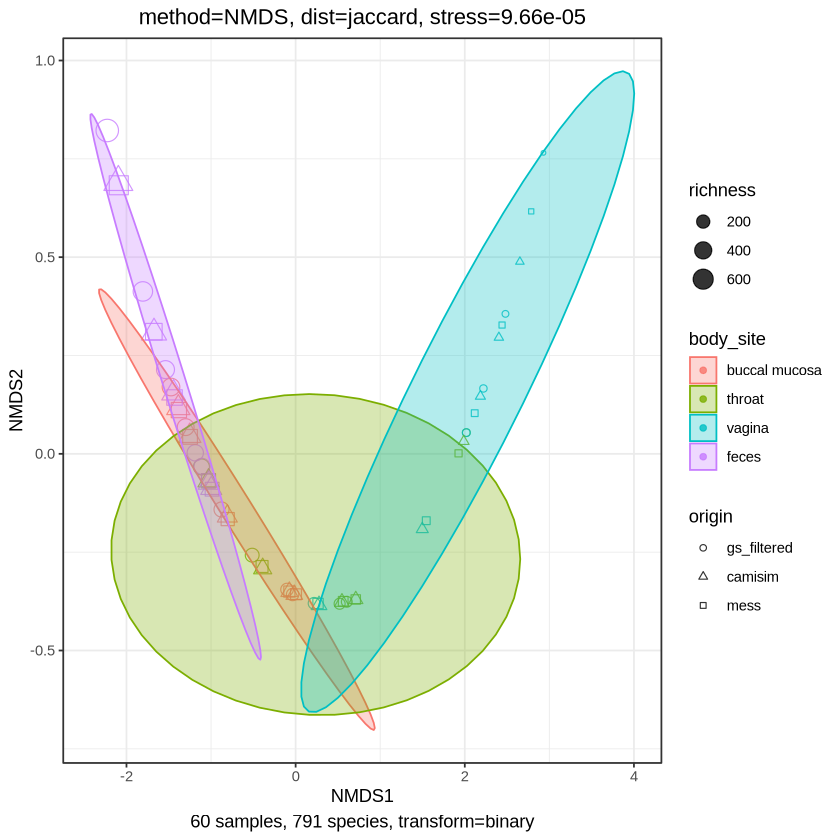

In [74]:
stress <-ord_get(ord)$stress
sample_count <- dim(samdat_tbl(ord))[1]
tax_count <- dim(tt_get(ord))[1]
p <- ord_plot(ord,
axes = c(1, 2),
auto_caption = NA,
colour = "body_site",
shape = "origin", alpha = 0.8,
size = "richness"
) + 
scale_shape_girafe_filled() +
stat_ellipse(geom = "polygon",aes(group = body_site, color = body_site, fill= body_site), alpha=0.3) +
theme_bw() +
ggtitle(sprintf("method=%s, dist=%s, stress=%s",method, dist,format(stress, digit=3))) +
labs(caption = sprintf("%s samples, %s %s, transform=%s",sample_count,tax_count,rank,trans)) +
theme(plot.caption = element_text(size = 11,hjust=0.5), plot.title = element_text(hjust=0.5))
p

In [75]:
#ggsave(sprintf("figures/%s-%s-%s.png",rank,dist,method),p, dpi = 400, units = "in")

Saving 6.67 x 6.67 in image


## Bray

In [76]:
dist = "bray"
method = "NMDS"
trans = "identity"
rank <- "species"
mdist <- ps %>%
 tax_transform(rank = rank, trans = trans) %>%
 dist_calc(dist = dist)
ord <- 
 ord_calc(mdist,
  method = method
 )

Run 0 stress 0.05555574 
Run 1 stress 0.05555574 
... New best solution
... Procrustes: rmse 1.627104e-05  max resid 6.074181e-05 
... Similar to previous best
Run 2 stress 0.05555574 
... Procrustes: rmse 5.301431e-06  max resid 2.405822e-05 
... Similar to previous best
Run 3 stress 0.05555574 
... Procrustes: rmse 6.209341e-06  max resid 2.702252e-05 
... Similar to previous best
Run 4 stress 0.4096329 
Run 5 stress 0.1241025 
Run 6 stress 0.05555574 
... New best solution
... Procrustes: rmse 5.785949e-06  max resid 2.735664e-05 
... Similar to previous best
Run 7 stress 0.143255 
Run 8 stress 0.05555574 
... Procrustes: rmse 4.760453e-06  max resid 2.514708e-05 
... Similar to previous best
Run 9 stress 0.1197913 
Run 10 stress 0.05555574 
... Procrustes: rmse 9.370022e-06  max resid 3.246529e-05 
... Similar to previous best
Run 11 stress 0.1195168 
Run 12 stress 0.119509 
Run 13 stress 0.05555574 
... Procrustes: rmse 7.078403e-06  max resid 2.79249e-05 
... Similar to previous 

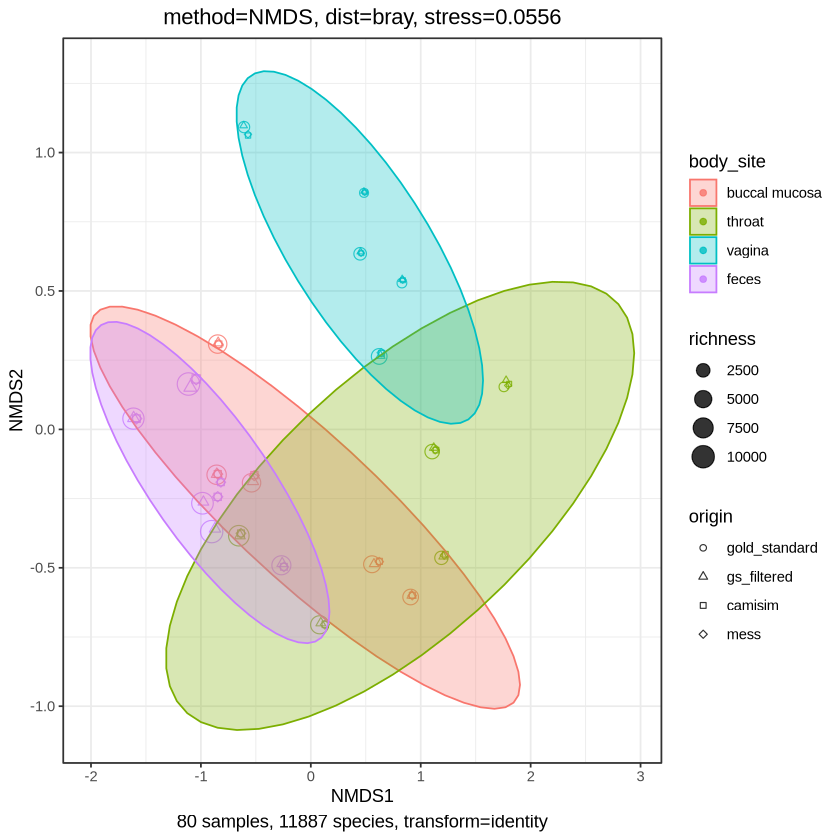

In [77]:
stress <-ord_get(ord)$stress
sample_count <- dim(samdat_tbl(ord))[1]
tax_count <- dim(tt_get(ord))[1]
p <- ord_plot(ord,
axes = c(1, 2),
auto_caption = NA,
colour = "body_site",
shape = "origin", alpha = 0.8,
size = "richness"
) + 
scale_shape_girafe_filled() +
stat_ellipse(geom = "polygon",aes(group = body_site, color = body_site, fill= body_site), alpha=0.3) +
theme_bw() +
ggtitle(sprintf("method=%s, dist=%s, stress=%s",method, dist,format(stress, digit=3))) +
labs(caption = sprintf("%s samples, %s %s, transform=%s",sample_count,tax_count,rank,trans)) +
theme(plot.caption = element_text(size = 11,hjust=0.5), plot.title = element_text(hjust=0.5))
p

In [ ]:
#ggsave(sprintf("figures/%s-%s-%s.png",rank,dist,method),p, dpi = 400, units = "in")

## PERMANOVA

In [78]:
perm <- dist_permanova(mdist,
    variables = "origin:simulated+body_site",
    n_perms = 999, 
    n_processes = 3
)
perm

2024-09-20 12:20:32.55799 - Starting PERMANOVA with 999 perms with 3 processes

2024-09-20 12:20:32.743715 - Finished PERMANOVA



psExtra object - a phyloseq object with extra slots:

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 11887 taxa and 80 samples ]
sample_data() Sample Data:       [ 80 samples by 6 sample variables ]
tax_table()   Taxonomy Table:    [ 11887 taxa by 7 taxonomic ranks ]

psExtra info:
tax_agg = "species" tax_trans = "identity" 

bray distance matrix of size 80 
0.01086067 0.8248204 0.830039 0.215534 0.2256189 ...

permanova:
Permutation test for adonis under reduced model
Marginal effects of terms
Permutation: free
Number of permutations: 999

vegan::adonis2(formula = formula, data = metadata, permutations = n_perms, by = by, parallel = parall)
                 Df SumOfSqs      R2       F Pr(>F)    
body_site         3   7.6793 0.42474 18.0205  0.001 ***
origin:simulated  3   0.0312 0.00172  0.0732  1.000    
Residual         73  10.3694 0.57353                   
Total            79  18.0799 1.00000                   
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01

## Beta dispersion

In [79]:
bd <- dist_bdisp(mdist, variables = c("origin","simulated","body_site")) %>%  bdisp_get()
bd

$origin
$origin$model

	Homogeneity of multivariate dispersions

Call: vegan::betadisper(d = distMat, group = meta[[V]], type = method)

No. of Positive Eigenvalues: 39
No. of Negative Eigenvalues: 40

Average distance to centroid:
gold_standard   gs_filtered       camisim          mess 
       0.4701        0.4708        0.4679        0.4677 

Eigenvalues for PCoA axes:
(Showing 8 of 79 eigenvalues)
 PCoA1  PCoA2  PCoA3  PCoA4  PCoA5  PCoA6  PCoA7  PCoA8 
9.5804 3.7629 2.4456 1.3672 0.6440 0.4219 0.2009 0.1749 

$origin$anova
Analysis of Variance Table

Response: Distances
          Df  Sum Sq   Mean Sq F value Pr(>F)
Groups     3 0.00015 0.0000498  0.0085 0.9989
Residuals 76 0.44307 0.0058299               

$origin$tukeyHSD
  Tukey multiple comparisons of means
    95% family-wise confidence level

Fit: aov(formula = distances ~ group, data = df)

$group
                                   diff         lwr        upr     p adj
gs_filtered-gold_standard  0.0007608947 -0.06266356 0.064

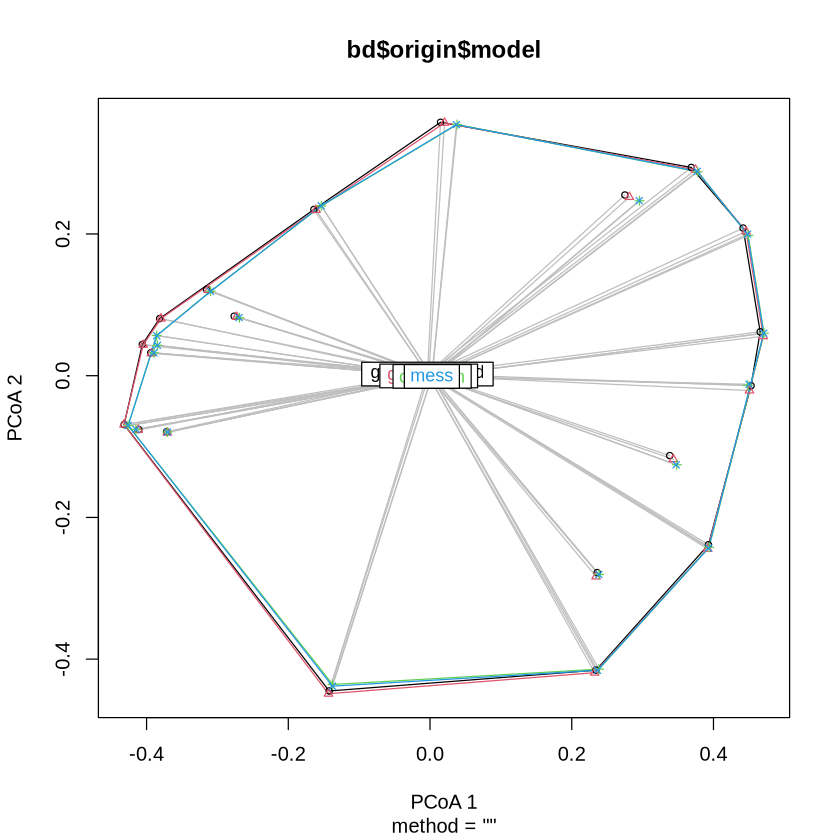

In [80]:
plot(bd$origin$model, label.cex = 0.9)

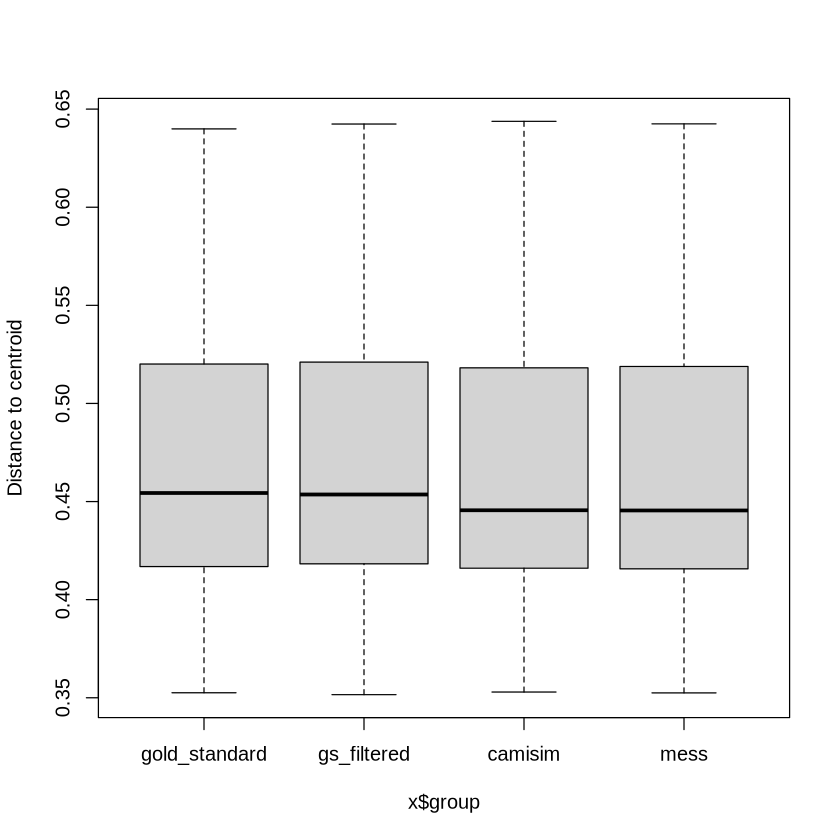

In [81]:
boxplot(bd$origin$model)

## Alpha diversities

In [17]:
alphadiv <- estimate_richness(ps, measures = c("Observed","Chao1","Shannon","Simpson",'InvSimpson'))
alphadiv$file <- rownames(alphadiv)
alphadiv <- inner_join(alphadiv, SAM, by="file") # add sample metadata
alphadiv <- subset(alphadiv, select = -c(richness,se.chao1,file))
alphadiv <- melt(alphadiv)
names(alphadiv) <- c("sample","origin","bodysite", "simulated","alpha","value")

Using sample, origin, body_site, simulated as id variables



In [86]:
head(alphadiv)

,sample,origin,bodysite,simulated,alpha,value
,<chr>,<fct>,<fct>,<fct>,<fct>,<dbl>
1,SRS013506,gold_standard,buccal mucosa,False,Observed,6033
2,SRS013506,gs_filtered,buccal mucosa,False,Observed,429
3,SRS014475,gold_standard,throat,False,Observed,3030
4,SRS014475,gs_filtered,throat,False,Observed,112
5,SRS014689,gold_standard,throat,False,Observed,8005
6,SRS014689,gs_filtered,throat,False,Observed,333


In [18]:
sim_alpha <- subset(alphadiv,origin=='mess')
names(sim_alpha)[names((sim_alpha))=='value']='sim_alpha'
real_alpha <- subset(alphadiv,origin=='gold_standard')
names(real_alpha)[names((real_alpha))=='value']='real_alpha'
df=cbind(real_alpha,sim_alpha)
df=subset(df, select=which(!duplicated(names(df)))) 
r <- 'spearman'
cor=round(cor(df$sim_alpha, df$real_alpha, method = r), 3)
cors <- ddply(df, c("alpha"), summarise, cor=round(cor(real_alpha, sim_alpha,method=r), 5))
cors$x=c(200,200,1.25,0.29,6.5)
cors$y=c(11000,11000,3,0.6,20)
cors$r2=round(cors$cor^2,2)
c <- ggplot(df,aes(x=sim_alpha,y=real_alpha))+geom_point()
c <- c+facet_wrap(~alpha,scales='free',ncol = 2)+geom_smooth(method = "lm", se = TRUE)
c <- c + geom_text(data=cors, aes(x=x,y=y,label=paste(r,"'s ","r2=", r2, sep="")))

`geom_smooth()` using formula = 'y ~ x'


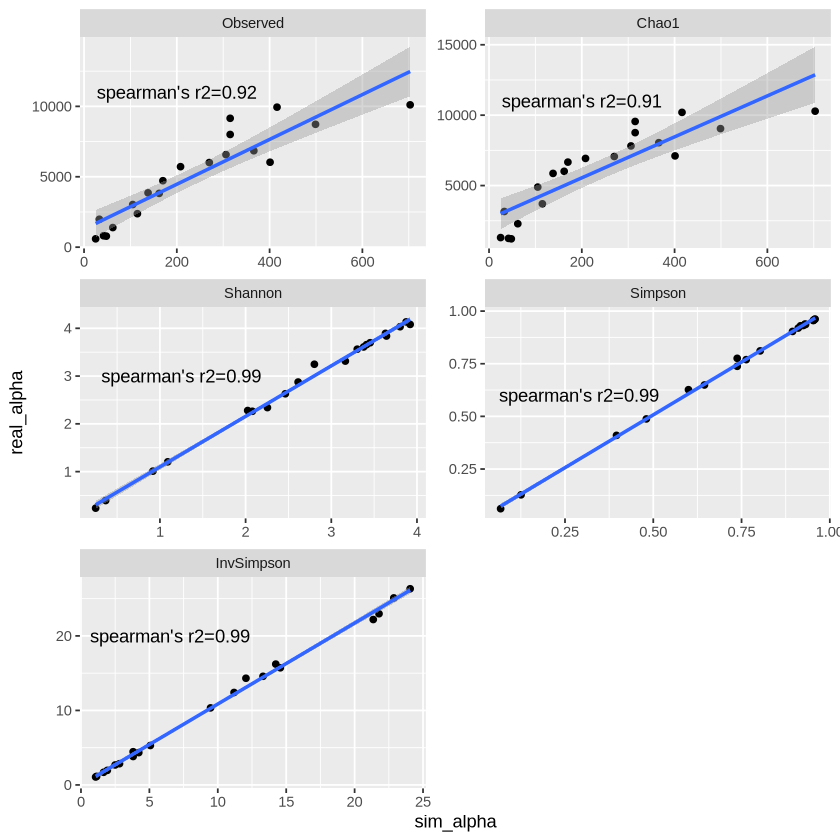

In [19]:
c

In [78]:
#ggsave("figures/alpha-divs.png",c, dpi = 400, units = "in")

Saving 6.67 x 6.67 in image
`geom_smooth()` using formula = 'y ~ x'
